In [1]:
import pandas as pd
import numpy as np
import glob
import os

## Read Clean data

In [2]:
# read clean data
df = pd.read_csv("filtered_df_dropped.csv")

In [3]:
print(df.shape)
df.columns

(61886, 30)


Index(['CountyOrParish', 'Levels', 'Latitude', 'NewConstructionYN',
       'GarageSpaces', 'BedroomsTotal', 'YearBuilt', 'StateOrProvince',
       'ClosePrice', 'LotSizeSquareFeet', 'LotSizeAcres',
       'BathroomsTotalInteger', 'StreetNumberNumeric', 'Longitude',
       'PostalCode', 'Stories', 'City', 'AssociationFee', 'ParkingTotal',
       'MainLevelBedrooms', 'LivingArea', 'Flooring', 'LotSizeArea',
       'UnparsedAddress', 'AttachedGarageYN', 'HighSchoolDistrict',
       'PoolPrivateYN', 'FireplaceYN', 'ViewYN', 'Month'],
      dtype='object')

## Special Columns

### 0. fillna helper

In [4]:
from sklearn.impute import SimpleImputer

# save training filling data for testset
FILLNA_STATS = {}

def safe_fill(df, columns, strategy='most_frequent', phase='train'):
    """
    Fill missing values for selected columns using the specified strategy.
    e.g. bool/text/classification features: 'most_frequent'.
    - phase='train'：save filling values
    - phase='test'：use saved values
    """
    from sklearn.impute import SimpleImputer
    global FILLNA_STATS

    if phase == 'train':
        for col in columns:
            imputer = SimpleImputer(strategy=strategy)
            df[[col]] = imputer.fit_transform(df[[col]])
            FILLNA_STATS[col] = imputer.statistics_[0]
    elif phase == 'test':
        for col in columns:
            if col not in FILLNA_STATS:
                raise ValueError(f"[safe_fill] Missing fill value for column '{col}'. Did you run training phase first?")
            fill_value = FILLNA_STATS[col]
            df[col] = df[col].fillna(fill_value)
    else:
        raise ValueError(f"[safe_fill] Unknown phase '{phase}', should be 'train' or 'test'")


### 1. Overlapping: Levels&Stories -- Creat: Level/Stories

In [5]:
### Levels
print(df.Levels.unique())
print(df['Levels'].value_counts(normalize=True, dropna=False))

['One' 'Two' nan 'ThreeOrMore' 'MultiSplit' 'One,Two'
 'ThreeOrMore,MultiSplit' 'Two,MultiSplit' 'One,MultiSplit'
 'One,Two,MultiSplit' 'Two,ThreeOrMore' 'One,ThreeOrMore'
 'One,Two,ThreeOrMore' 'One,Two,ThreeOrMore,MultiSplit'
 'Two,ThreeOrMore,MultiSplit']
Levels
One                               0.566655
Two                               0.305626
NaN                               0.087807
ThreeOrMore                       0.019164
MultiSplit                        0.014801
One,Two                           0.002117
Two,MultiSplit                    0.001664
ThreeOrMore,MultiSplit            0.000759
One,MultiSplit                    0.000663
Two,ThreeOrMore                   0.000355
One,ThreeOrMore                   0.000210
One,Two,MultiSplit                0.000065
One,Two,ThreeOrMore               0.000048
One,Two,ThreeOrMore,MultiSplit    0.000032
Two,ThreeOrMore,MultiSplit        0.000032
Name: proportion, dtype: float64


In [6]:
df.Stories.unique()

array([ 1.,  2., nan])

In [7]:
df.Stories.dtype

dtype('float64')

In [8]:
def clean_levels(val):
    if pd.isna(val):
        return np.nan
    levels = str(val).split(',')
    levels_set = set(levels)

    # noise infor, ignore
    if (levels_set == {'One', 'Two', 'ThreeOrMore', 'MultiSplit'}) or (levels_set == {'MultiSplit'}):
        return np.nan
    # for other situation, get max clear number,e.g.: One,Two,ThreeOrMore -> 2
    score = 0
    for level in levels:
        if 'Three' in level:
            score = max(score, 3)
        elif 'Two' in level:
            score = max(score, 2)
        elif 'One' in level:
            score = max(score, 1)
    return score if score > 0 else np.nan

df['Levels'] = df['Levels'].apply(clean_levels)

# fillna
df['Levels'] = df['Levels'].fillna(1).astype(int)
safe_fill(df, ['Stories'], strategy='most_frequent',phase='train')

######## creat a new col: LevelStoryRatio 
# Helps distinguish between standalone homes and units within multi-story buildings.
# Useful as a proxy for property independence or relative vertical position.

# Level / Stories
df['LevelStoryRatio'] = df['Levels'] / df['Stories']

# replace inf / NaN
df['LevelStoryRatio'] = df['LevelStoryRatio'].replace([np.inf, -np.inf], np.nan)
df['LevelStoryRatio'] = df['LevelStoryRatio'].fillna(0)

# replace extreme values
df['LevelStoryRatio'] = df['LevelStoryRatio'].clip(upper=1.0)
df.drop('Stories',axis = 1, inplace = True)

In [9]:
print(df.LevelStoryRatio.unique())
print(df.Levels.unique())

[1.]
[1 2 3]


### 2. Duplicates: LotSizeArea & LotSizeAcres & LotSizeSquareFeet
#### keep: LotSizeSquareFeet

In [10]:
print(f"LotSizeArea NaN ratio: {df.LotSizeAcres.isna().mean()}")
print(f"LotSizeAcres NaN ratio: {df.LotSizeArea.isna().mean()}")
print(f"LotSizeSquareFeet NaN ratio: {df.LotSizeSquareFeet.isna().mean()}")

LotSizeArea NaN ratio: 0.018210903920111172
LotSizeAcres NaN ratio: 0.01811395145913454
LotSizeSquareFeet NaN ratio: 0.01814626894612675


In [11]:
comparison = (df['LotSizeSquareFeet'] == df['LotSizeArea']) | (
    df['LotSizeSquareFeet'].isna() & df['LotSizeArea'].isna())
match_ratio = comparison.mean()
print(f"Proportion of rows where values match: {match_ratio:.2%}")
df.drop(columns=['LotSizeArea'], inplace=True)

Proportion of rows where values match: 97.61%


In [12]:
# only keep LotSizeSquareFeet, create LotSizeSquareFeet/LotSizeAcres to show possible miss inputing
# ratio should be：43560
df['LotSizeRatio'] = df['LotSizeSquareFeet']/df['LotSizeAcres']
df['LotSizeRatio'] = df['LotSizeRatio'].replace([np.inf, -np.inf], np.nan)
df['LotSizeMismatch'] = ((df['LotSizeRatio'] < 40000) | (df['LotSizeRatio'] > 50000)).astype(int)
print(f"number of possible miss input observations: {df['LotSizeMismatch'].sum()}")
print("drop above 6 observations and col: LotSizeRatio&LotSizeMismatch")
df = df[df['LotSizeMismatch'] == 0]
df.drop(columns=['LotSizeMismatch', 'LotSizeRatio', 'LotSizeAcres'], inplace=True, errors = 'ignore')

number of possible miss input observations: 6
drop above 6 observations and col: LotSizeRatio&LotSizeMismatch


In [13]:
print(df.columns,df.shape)

Index(['CountyOrParish', 'Levels', 'Latitude', 'NewConstructionYN',
       'GarageSpaces', 'BedroomsTotal', 'YearBuilt', 'StateOrProvince',
       'ClosePrice', 'LotSizeSquareFeet', 'BathroomsTotalInteger',
       'StreetNumberNumeric', 'Longitude', 'PostalCode', 'City',
       'AssociationFee', 'ParkingTotal', 'MainLevelBedrooms', 'LivingArea',
       'Flooring', 'UnparsedAddress', 'AttachedGarageYN', 'HighSchoolDistrict',
       'PoolPrivateYN', 'FireplaceYN', 'ViewYN', 'Month', 'LevelStoryRatio'],
      dtype='object') (61880, 28)


### 3. Geographic Features

#### 3.1 City

In [14]:
print(f"total cities number: {len(df.City.unique())}")
city_stats = (
    df['City']
    .value_counts(normalize=False)
    .to_frame(name='Count')
    .assign(Frequency=lambda x: x['Count'] / len(df))
    .sort_values(by='Count', ascending=False)
)
city_stats

total cities number: 867


,Count,Frequency
City,,
Los Angeles,2515,0.040643
San Diego,2128,0.034389
San Jose,1139,0.018407
Riverside,943,0.015239
Oakland,789,0.012750
...,...,...
Boulevard,1,0.000016
Dulzura,1,0.000016
Laguna Woods,1,0.000016


In [15]:
# fillna
safe_fill(df, ['City'], strategy='most_frequent',phase='train')

# freq(normalize)
city_freq = df['City'].value_counts(normalize=True)

# Add CityFreq replace City, tell the model which City are more common and potentially more influential on ClosePrice.
df['CityFreq'] = df['City'].map(city_freq)

# Creat feature to mark very rare Cities -- IsRareCity
threshold = df['CityFreq'].quantile(0.05)
df['IsRareCity'] = (df['CityFreq'] < threshold).astype(int)

#### 3.2 KMeans Cluster to categorize regions 

In [16]:
from sklearn.cluster import KMeans
# fillna
safe_fill(df, ['Latitude', 'Longitude'], strategy='median', phase='train')

def create_latlon_cluster(df, n_clusters=10):
    coords = df[['Latitude', 'Longitude']].dropna()
    model = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = model.fit_predict(coords)
    df.loc[coords.index, 'LatLonCluster'] = cluster_labels
    df['LatLonCluster'] = df['LatLonCluster'].fillna(-1).astype(int)
    return model  

kmeans_model = create_latlon_cluster(df, n_clusters=10)

#### 3.3 Latitude & Longitude --> LatBin & LonBin

In [17]:
def create_latlon_bins(df, lat_bin_size=0.1, lon_bin_size=0.1):
    df['LatBin'] = (df['Latitude'] / lat_bin_size).round().astype('Int64')
    df['LonBin'] = (df['Longitude'] / lon_bin_size).round().astype('Int64')
create_latlon_bins(df, lat_bin_size=0.1, lon_bin_size=0.1)
df.drop(columns = ['Latitude','Longitude'], inplace = True)

#### 3.4 PostalCode

In [18]:
print(f"postal code total unique: {len(df.PostalCode.unique())}")
safe_fill(df, ['PostalCode'], strategy='most_frequent', phase='train')
postal_freq = df['PostalCode'].value_counts(normalize=True)
df['PostalCodeFreq'] = df['PostalCode'].map(postal_freq)

postal code total unique: 1616


#### 3.5 StateOrProvince

In [19]:
print(df.StateOrProvince.value_counts(normalize = True))
df.drop("StateOrProvince",axis = 1,inplace = True)

StateOrProvince
CA    0.999919
AZ    0.000032
TN    0.000016
CO    0.000016
OS    0.000016
Name: proportion, dtype: float64


#### 3.6 CountyOrParish

In [20]:
df.CountyOrParish.unique()

array(['San Diego', 'Riverside', 'Los Angeles', 'Monterey',
       'San Luis Obispo', 'Orange', 'Santa Clara', 'San Mateo',
       'Contra Costa', 'Alameda', 'Santa Cruz', 'Ventura',
       'San Francisco', 'San Bernardino', 'Butte', 'Sutter', 'Kern',
       'San Joaquin', 'Solano', 'Merced', 'Lake', 'Sacramento',
       'Mendocino', 'Yolo', 'San Benito', 'Tulare', 'Napa', 'Kings',
       'Fresno', 'Santa Barbara', 'Madera', 'Placer', 'Glenn',
       'Stanislaus', 'Amador', 'Sonoma', 'Marin', 'Yuba', 'Tehama',
       'Plumas', 'Calaveras', 'Imperial', 'Nevada', 'Trinity', 'Inyo',
       'Tuolumne', 'Mariposa', 'Mono', 'Other', 'Del Norte',
       'Other State', 'Shasta', 'Colusa', 'Siskiyou', 'Foreign Country',
       'El Dorado', 'Humboldt'], dtype=object)

In [21]:
print(f"total cities number: {len(df.CountyOrParish.unique())}")
CountyOrParish_stats = (
    df['CountyOrParish']
    .value_counts(normalize=False)
    .to_frame(name='Count')
    .assign(Frequency=lambda x: x['Count'] / len(df))
    .sort_values(by='Count', ascending=False)
)
CountyOrParish_stats # longtail

total cities number: 57


,Count,Frequency
CountyOrParish,,
Los Angeles,15227,0.246073
Riverside,9790,0.158209
San Diego,6760,0.109244
San Bernardino,6641,0.107321
Orange,5887,0.095136
Alameda,2816,0.045507
Contra Costa,2774,0.044829
Santa Clara,2166,0.035003
Ventura,1918,0.030995


In [22]:
df.CountyOrParish.isna().mean

<bound method Series.mean of 0        False
1        False
2        False
3        False
4        False
         ...  
61881    False
61882    False
61883    False
61884    False
61885    False
Name: CountyOrParish, Length: 61880, dtype: bool>

In [23]:
safe_fill(df, ['CountyOrParish'], strategy='most_frequent', phase='train')
# add freq
County_freq = df['CountyOrParish'].value_counts(normalize=True)
df['CountyFreq'] = df['CountyOrParish'].map(County_freq)
# add israre
threshold = df['CountyFreq'].quantile(0.05)
df['IsRareCounty'] = (df['CountyFreq'] < threshold).astype(int)

#### 3.7 StreetNumberNumeric & UnparsedAddress

In [24]:
df.drop(columns = ['StreetNumberNumeric','UnparsedAddress'], inplace = True)

### 4. HighSchoolDistrict
create: HighSchoolDistrictFreq & IsRareDistrict

In [25]:
print(df.HighSchoolDistrict.isna().sum())
print(len(df.HighSchoolDistrict.unique()))

16373
399


In [26]:
print(f"total district number: {len(df.HighSchoolDistrict.unique())}")
district_stats = (
    df['HighSchoolDistrict']
    .value_counts(normalize=False)
    .to_frame(name='Count')
    .assign(Frequency=lambda x: x['Count'] / len(df))
    .sort_values(by='Count', ascending=False)
)
district_stats

total district number: 399


,Count,Frequency
HighSchoolDistrict,,
Other,4251,0.068697
Los Angeles Unified,3744,0.060504
Capistrano Unified,1113,0.017986
Riverside Unified,833,0.013462
Corona-Norco Unified,794,0.012831
...,...,...
Round Valley Unified,1,0.000016
Manton Joint Unified,1,0.000016
Bret Harte Union,1,0.000016


In [27]:
# fillna
safe_fill(df, ['HighSchoolDistrict'], strategy='most_frequent',phase='train')
# freq(normalize)
district_freq = df['HighSchoolDistrict'].value_counts(normalize=True)

# Add HighSchoolDistrictFreq to guide the model on which school districts are more common and potentially more influential on ClosePrice.
df['HighSchoolDistrictFreq'] = df['HighSchoolDistrict'].map(district_freq)

In [28]:
rare = (df['HighSchoolDistrictFreq'] < 0.005)
rare.sum()

np.int64(19922)

In [29]:
# Creat feature to mark very rare districts -- IsRareDistrict
threshold = df['HighSchoolDistrictFreq'].quantile(0.05)
df['IsRareDistrict'] = (df['HighSchoolDistrictFreq'] < threshold).astype(int)
print(f"Rare cutoff: {threshold:.5f}")
print(f"Rare count: {df['IsRareDistrict'].sum()} rows")

Rare cutoff: 0.00078
Rare count: 3077 rows


### 5. Bool Features

In [30]:
###### Bool Attributes
bool_cols = ['AttachedGarageYN', 'PoolPrivateYN', 'ViewYN',
    'NewConstructionYN', 'FireplaceYN']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].map({True: 1, False: 0}).astype(float)

In [31]:
for col in bool_cols:
    print(f"{col}: % missing = {df[col].isna().mean():.2%}, unique = {df[col].unique()}")

AttachedGarageYN: % missing = 11.73%, unique = [nan  1.  0.]
PoolPrivateYN: % missing = 8.76%, unique = [ 0.  1. nan]
ViewYN: % missing = 8.70%, unique = [ 0.  1. nan]
NewConstructionYN: % missing = 7.28%, unique = [ 0.  1. nan]
FireplaceYN: % missing = 0.06%, unique = [ 0.  1. nan]


In [32]:
# fillna
for col in bool_cols:
    safe_fill(df, [col], strategy='most_frequent',phase='train')

### 6. Flooring

In [33]:
print(df.Flooring.unique()[0:10])
print(df.Flooring.isna().sum())
floorfreq = df.Flooring.value_counts(normalize=True).to_frame(name = "freq").sort_values(by = "freq",ascending = False)
floorfreq[:20]

['Carpet,Tile' nan 'Tile' 'Stone' 'Wood' 'Vinyl' 'Carpet,Vinyl'
 'Tile,Wood' 'Carpet,Stone,Wood' 'Carpet,Laminate']
22323


,freq
Flooring,
"Carpet,Tile",0.114392
Wood,0.101752
"Tile,Wood",0.082135
Laminate,0.076093
"Carpet,Tile,Wood",0.059282
Tile,0.055035
Vinyl,0.050383
"Laminate,Tile",0.046717
"Carpet,Laminate",0.046010


In [34]:
known_materials = ['Carpet', 'Tile', 'Wood', 'Laminate', 'Vinyl', 'Stone', 'Concrete', 'Bamboo']
for material in known_materials:
    df[f'Has{material}'] = df['Flooring'].fillna('').str.contains(material, case=False).astype(int)
df['FlooringMissing'] = df['Flooring'].isna().astype(int)
df.drop("Flooring", axis = 1, inplace = True)

In [35]:
df.iloc[0:6,-9:-1]

,HasCarpet,HasTile,HasWood,HasLaminate,HasVinyl,HasStone,HasConcrete,HasBamboo
0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0


In [36]:
df.columns

Index(['CountyOrParish', 'Levels', 'NewConstructionYN', 'GarageSpaces',
       'BedroomsTotal', 'YearBuilt', 'ClosePrice', 'LotSizeSquareFeet',
       'BathroomsTotalInteger', 'PostalCode', 'City', 'AssociationFee',
       'ParkingTotal', 'MainLevelBedrooms', 'LivingArea', 'AttachedGarageYN',
       'HighSchoolDistrict', 'PoolPrivateYN', 'FireplaceYN', 'ViewYN', 'Month',
       'LevelStoryRatio', 'CityFreq', 'IsRareCity', 'LatLonCluster', 'LatBin',
       'LonBin', 'PostalCodeFreq', 'CountyFreq', 'IsRareCounty',
       'HighSchoolDistrictFreq', 'IsRareDistrict', 'HasCarpet', 'HasTile',
       'HasWood', 'HasLaminate', 'HasVinyl', 'HasStone', 'HasConcrete',
       'HasBamboo', 'FlooringMissing'],
      dtype='object')

In [37]:
lot_cols = [col for col in df.columns if 'Lot' in col]
print(lot_cols)

['LotSizeSquareFeet']


## Abnormal values

In [38]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
for col in num_cols:
    print(col)
    print(df[col].describe())

Levels
count    61880.000000
mean         1.350598
std          0.518455
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: Levels, dtype: float64
NewConstructionYN
count    61880.000000
mean         0.036991
std          0.188741
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: NewConstructionYN, dtype: float64
GarageSpaces
count    59539.000000
mean         1.990141
std          2.615255
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        400.000000
Name: GarageSpaces, dtype: float64
BedroomsTotal
count    61880.000000
mean         3.475598
std          0.978007
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         45.000000
Name: BedroomsTotal, dtype: float64
YearBuilt
count    61823.000000
mean      1975.846724
std         27.648735
min       1800.000000
25%   

In [39]:
df.ParkingTotal.value_counts(normalize = True)

ParkingTotal
2.0      0.527311
3.0      0.132870
4.0      0.108630
1.0      0.066564
0.0      0.056658
           ...   
60.0     0.000016
480.0    0.000016
775.0    0.000016
76.0     0.000016
35.0     0.000016
Name: proportion, Length: 86, dtype: float64

In [40]:
CAP_STATS = {}  # global value
def cap_g99(df, cols, phase='train'):
    global CAP_STATS
    for col in cols:
        if col in df.columns:
            if phase == 'train':
                cap = df[col].quantile(0.99)
                CAP_STATS[col] = cap
            else:  # test
                cap = CAP_STATS.get(col)
                if cap is None:
                    raise ValueError(f"[cap_g99] Missing cap value for '{col}'")
            df[col] = np.where(df[col] > cap, cap, df[col])

In [41]:
cap_cols = [
    'LotSizeSquareFeet', 'AssociationFee', 'BathroomsTotalInteger',
    'BedroomsTotal', 'LivingArea', 'GarageSpaces'
]
cap_g99(df, cap_cols, phase='train')

# ParkingTotal: remove negatives, then cap
df['ParkingTotal'] = df['ParkingTotal'].mask(df['ParkingTotal'] < 0, np.nan)
df['ParkingTotal'] = np.where(df['ParkingTotal'] > 50, 50, df['ParkingTotal'])

# MainLevelBedrooms
df['MainLevelBedrooms'] = np.where(df['MainLevelBedrooms'] > 10, 10, df['MainLevelBedrooms'])

# YearBuilt
df['YearBuilt'] = np.where(df['YearBuilt'] > 2025, 2025, df['YearBuilt'])

## fillna

In [42]:
# fillna
# by median
median_cols = [
    'MainLevelBedrooms', 'GarageSpaces','LotSizeSquareFeet',
    'YearBuilt', 'LivingArea', 'ParkingTotal',
    'BathroomsTotalInteger', 'AssociationFee'
]
for col in median_cols:
    safe_fill(df, [col], strategy='median', phase='train')
    
df = df.dropna(subset=['ClosePrice'])


In [43]:
df.isna().sum()

CountyOrParish            0
Levels                    0
NewConstructionYN         0
GarageSpaces              0
BedroomsTotal             0
YearBuilt                 0
ClosePrice                0
LotSizeSquareFeet         0
BathroomsTotalInteger     0
PostalCode                0
City                      0
AssociationFee            0
ParkingTotal              0
MainLevelBedrooms         0
LivingArea                0
AttachedGarageYN          0
HighSchoolDistrict        0
PoolPrivateYN             0
FireplaceYN               0
ViewYN                    0
Month                     0
LevelStoryRatio           0
CityFreq                  0
IsRareCity                0
LatLonCluster             0
LatBin                    0
LonBin                    0
PostalCodeFreq            0
CountyFreq                0
IsRareCounty              0
HighSchoolDistrictFreq    0
IsRareDistrict            0
HasCarpet                 0
HasTile                   0
HasWood                   0
HasLaminate         

In [44]:
df.columns

Index(['CountyOrParish', 'Levels', 'NewConstructionYN', 'GarageSpaces',
       'BedroomsTotal', 'YearBuilt', 'ClosePrice', 'LotSizeSquareFeet',
       'BathroomsTotalInteger', 'PostalCode', 'City', 'AssociationFee',
       'ParkingTotal', 'MainLevelBedrooms', 'LivingArea', 'AttachedGarageYN',
       'HighSchoolDistrict', 'PoolPrivateYN', 'FireplaceYN', 'ViewYN', 'Month',
       'LevelStoryRatio', 'CityFreq', 'IsRareCity', 'LatLonCluster', 'LatBin',
       'LonBin', 'PostalCodeFreq', 'CountyFreq', 'IsRareCounty',
       'HighSchoolDistrictFreq', 'IsRareDistrict', 'HasCarpet', 'HasTile',
       'HasWood', 'HasLaminate', 'HasVinyl', 'HasStone', 'HasConcrete',
       'HasBamboo', 'FlooringMissing'],
      dtype='object')

In [45]:
df.to_csv("dfBeforeRF.csv",index = False)

In [46]:
df.Month.unique()

array(['2025-01', '2025-03', '2025-02', '2025-05', '2025-04', '2024-12'],
      dtype=object)

In [47]:
FILLNA_STATS

{'Stories': np.float64(1.0),
 'City': 'Los Angeles',
 'Latitude': np.float64(34.077849),
 'Longitude': np.float64(-118.017969),
 'PostalCode': '92253',
 'CountyOrParish': 'Los Angeles',
 'HighSchoolDistrict': 'Other',
 'AttachedGarageYN': np.float64(1.0),
 'PoolPrivateYN': np.float64(0.0),
 'ViewYN': np.float64(1.0),
 'NewConstructionYN': np.float64(0.0),
 'FireplaceYN': np.float64(1.0),
 'MainLevelBedrooms': np.float64(3.0),
 'GarageSpaces': np.float64(2.0),
 'LotSizeSquareFeet': np.float64(7259.0),
 'YearBuilt': np.float64(1976.0),
 'LivingArea': np.float64(1803.0),
 'ParkingTotal': np.float64(2.0),
 'BathroomsTotalInteger': np.float64(2.0),
 'AssociationFee': np.float64(0.0)}

In [48]:
FREQ_MAPS = {}
FREQ_MAPS['CityFreq'] = city_freq
FREQ_MAPS['PostalCodeFreq'] = postal_freq
FREQ_MAPS['CountyFreq'] = County_freq
FREQ_MAPS['HighSchoolDistrictFreq'] = district_freq

## random forest

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## TimeWindow Training

### 1.1 sliding functiojn

In [74]:
def run_sliding_random_forest(df, feature_cols, target_col='ClosePrice', month_col='Month',
                               model_params=None, verbose=True):
    """
    Perform 3+1 sliding window training using Random Forest on monthly real estate data.

    Parameters:
    - df: dataframe including 6 months:2412-2505
    - feature_cols: list of features to use for modeling.
    - target_col: name of the target column: 'ClosePrice'
    - month_col: name of the time-based splitting column: 'Month'
    - model_params: dictionary of RandomForestRegressor parameters (optional).
    - verbose: print evaluation details for each window.

    Returns:
    - results_df: DataFrame with RMSE, MAE, and R2 for each window.
    - all_importances_df: DataFrame with feature importances for each window (indexed by ValMonth).
    - mean_importance_df: DataFrame with average feature importance across all windows.
    """
    months = sorted(df[month_col].unique())
    results = []
    all_importances = []

    if model_params is None:
        model_params = {'n_estimators': 100, 'random_state': 42}

    for i in range(len(months) - 3):
        train_months = months[i:i+3]
        val_month = months[i+3]

        train_df = df[df[month_col].isin(train_months)].copy()
        val_df = df[df[month_col] == val_month].copy()

        X_train = train_df[feature_cols]
        y_train = np.log1p(train_df[target_col])

        X_val = val_df[feature_cols]
        y_val = np.log1p(val_df[target_col])

        model = RandomForestRegressor(**model_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # go back to real price
        y_pred_actual = np.expm1(y_pred)
        y_val_actual = np.expm1(y_val)

        rmse = mean_squared_error(y_val_actual, y_pred_actual)**0.5
        mae = mean_absolute_error(y_val_actual, y_pred_actual)
        r2 = r2_score(y_val, y_pred)

        results.append({
            'TrainMonths': train_months,
            'ValMonth': val_month,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

        importances = pd.Series(model.feature_importances_, index=feature_cols)
        importances.name = val_month
        all_importances.append(importances)

        if verbose:
            print(f"Train: {train_months} → Val: {val_month} | RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

    results_df = pd.DataFrame(results)
    all_importances_df = pd.DataFrame(all_importances)
    mean_importance_df = all_importances_df.mean().sort_values(ascending=False).to_frame(name="MeanImportance")

    return results_df, all_importances_df, mean_importance_df


### 1.2 grid search

In [75]:
# grid search
drop_cols = ['ClosePrice', 'Month', 'City', 'CountyOrParish', 'PostalCode', 'HighSchoolDistrict']
feature_cols = df.columns.difference(drop_cols)

depth_list = [5, 10, 15, 20, None]
estimator_list = [50, 100, 200, 300]

results_grid = []
feature_importance_grid = []

for depth in depth_list:
    for n_est in estimator_list:
        print(f"→ Testing max_depth={depth}, n_estimators={n_est}")
        
        result_df, all_importance_df, mean_importance_df = run_sliding_random_forest(
            df,
            feature_cols.tolist(),
            model_params={'max_depth': depth, 'n_estimators': n_est},
            verbose=False
        )
        
        avg_rmse = result_df['RMSE'].mean()
        avg_mae = result_df['MAE'].mean()
        avg_r2 = result_df['R2'].mean()
        
        result_df['max_depth'] = depth
        result_df['n_estimators'] = n_est
        mean_importance_df['max_depth'] = depth
        mean_importance_df['n_estimators'] = n_est

        results_grid.append(result_df)
        feature_importance_grid.append({
            'depth': depth,
            'n_est': n_est,
            'mean_importance': mean_importance_df,
            'raw_importance': all_importance_df  # raw importance for every window
        })
        
        print(f"   Avg RMSE: {avg_rmse:.2f}, Avg MAE: {avg_mae:.2f}, Avg R2: {avg_r2:.4f}")

→ Testing max_depth=5, n_estimators=50
   Avg RMSE: 5211005.16, Avg MAE: 457935.14, Avg R2: 0.6524
→ Testing max_depth=5, n_estimators=100
   Avg RMSE: 5211226.21, Avg MAE: 458426.30, Avg R2: 0.6506
→ Testing max_depth=5, n_estimators=200
   Avg RMSE: 5211317.87, Avg MAE: 458009.42, Avg R2: 0.6519
→ Testing max_depth=5, n_estimators=300
   Avg RMSE: 5211091.39, Avg MAE: 457712.35, Avg R2: 0.6526
→ Testing max_depth=10, n_estimators=50
   Avg RMSE: 5116021.63, Avg MAE: 340021.81, Avg R2: 0.8248
→ Testing max_depth=10, n_estimators=100
   Avg RMSE: 5112579.16, Avg MAE: 338385.98, Avg R2: 0.8263
→ Testing max_depth=10, n_estimators=200
   Avg RMSE: 5112365.38, Avg MAE: 337615.92, Avg R2: 0.8269
→ Testing max_depth=10, n_estimators=300
   Avg RMSE: 5110060.11, Avg MAE: 338115.46, Avg R2: 0.8265
→ Testing max_depth=15, n_estimators=50
   Avg RMSE: 5086790.55, Avg MAE: 296934.46, Avg R2: 0.8651
→ Testing max_depth=15, n_estimators=100
   Avg RMSE: 5087225.18, Avg MAE: 297153.04, Avg R2: 0.86

In [69]:
df.ClosePrice.describe()

count    6.187900e+04
mean     1.291394e+06
std      4.851862e+06
min      1.150000e+00
25%      6.249000e+05
50%      8.900000e+05
75%      1.435000e+06
max      9.700000e+08
Name: ClosePrice, dtype: float64

### 1.3 Choose maxdepth & nestimators

In [86]:
all_results = pd.concat(results_grid, ignore_index=True)
print(all_results[all_results['max_depth'].isin([15, 20])])

                    TrainMonths ValMonth          RMSE            MAE  \
24  [2024-12, 2025-01, 2025-02]  2025-03  6.718783e+05  249445.254377   
25  [2025-01, 2025-02, 2025-03]  2025-04  8.942883e+06  333911.967795   
26  [2025-02, 2025-03, 2025-04]  2025-05  5.645610e+06  307446.155612   
27  [2024-12, 2025-01, 2025-02]  2025-03  6.702507e+05  249316.154453   
28  [2025-01, 2025-02, 2025-03]  2025-04  8.941657e+06  334091.721988   
29  [2025-02, 2025-03, 2025-04]  2025-05  5.649768e+06  308051.256791   
30  [2024-12, 2025-01, 2025-02]  2025-03  6.754125e+05  248950.872587   
31  [2025-01, 2025-02, 2025-03]  2025-04  8.940162e+06  331382.568853   
32  [2025-02, 2025-03, 2025-04]  2025-05  5.650010e+06  307173.504233   
33  [2024-12, 2025-01, 2025-02]  2025-03  6.751859e+05  248456.624048   
34  [2025-01, 2025-02, 2025-03]  2025-04  8.941133e+06  332348.823247   
35  [2025-02, 2025-03, 2025-04]  2025-05  5.646533e+06  306188.495806   
36  [2024-12, 2025-01, 2025-02]  2025-03  6.698114e

choose max_depth = 20, estimators = 200, maybe a graph here?

### 1.4 Choose Important Feartures

In [90]:
# concact all feature_importance form
all_importance_rows = []

for entry in feature_importance_grid:
    raw_df = entry['raw_importance'].copy()
    raw_df['max_depth'] = entry['depth']
    raw_df['n_estimators'] = entry['n_est']
    all_importance_rows.append(raw_df)

raw_importance_all = pd.concat(all_importance_rows, axis=0, ignore_index=True)

# melt to long form
importance_long = raw_importance_all.melt(
    id_vars=['max_depth', 'n_estimators'],
    var_name='feature',
    value_name='importance'
)

# mean std cv for each feature under 3 window
feature_stats_full = importance_long.groupby('feature')['importance'].agg(['mean', 'std'])
feature_stats_full['cv'] = feature_stats_full['std'] / feature_stats_full['mean']
feature_stats_full = feature_stats_full.sort_values(by=['mean'], ascending=[False])


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [94]:
feature_stats_full

,mean,std,cv
feature,,,
LivingArea,0.236389,0.041351,0.174929
BathroomsTotalInteger,0.210938,0.052058,0.246794
LatBin,0.154615,0.012989,0.084006
LatLonCluster,0.129775,0.024925,0.192065
LonBin,0.066376,0.022820,0.343797
PostalCodeFreq,0.046468,0.004772,0.102705
CountyFreq,0.035995,0.007365,0.204596
CityFreq,0.021641,0.008784,0.405880
LotSizeSquareFeet,0.018788,0.011787,0.627348


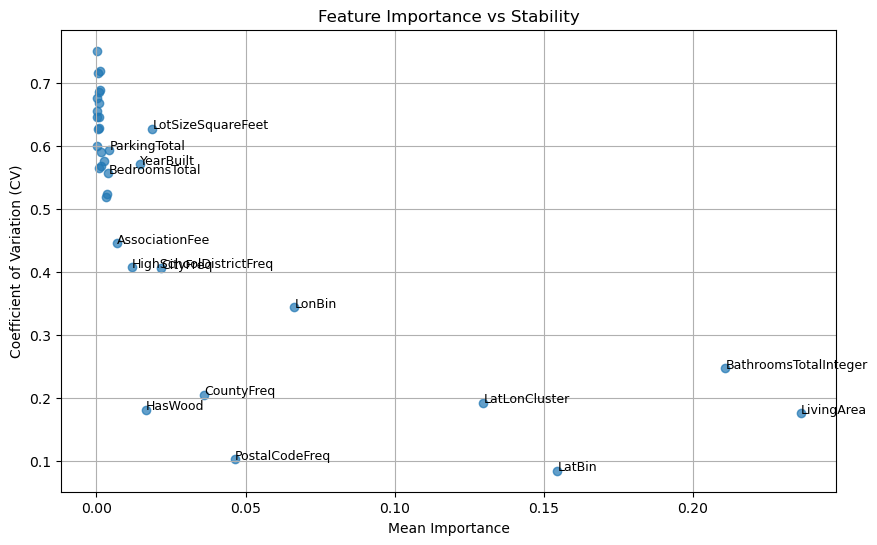

In [93]:
plt.figure(figsize=(10, 6))
plt.scatter(
    feature_stats_full['mean'],
    feature_stats_full['cv'],
    alpha=0.7
)

for i, row in feature_stats_full.head(15).iterrows():
    plt.text(row['mean'], row['cv'], row.name, fontsize=9)

plt.xlabel('Mean Importance')
plt.ylabel('Coefficient of Variation (CV)')
plt.title('Feature Importance vs Stability')
plt.grid(True)
plt.show()

In [97]:
# only 3 windows, std&cv not so robust. focusing on featrues where mean>0.001 
final_featrues = feature_stats_full[feature_stats_full["mean"]>0.001].index.tolist()
final_featrues

['LivingArea',
 'BathroomsTotalInteger',
 'LatBin',
 'LatLonCluster',
 'LonBin',
 'PostalCodeFreq',
 'CountyFreq',
 'CityFreq',
 'LotSizeSquareFeet',
 'HasWood',
 'YearBuilt',
 'HighSchoolDistrictFreq',
 'AssociationFee',
 'ParkingTotal',
 'BedroomsTotal',
 'PoolPrivateYN',
 'GarageSpaces',
 'MainLevelBedrooms',
 'Levels',
 'FireplaceYN',
 'ViewYN',
 'HasCarpet']

In [98]:
df[['GarageSpaces', 'ParkingTotal']].corr() # not duplicate

,GarageSpaces,ParkingTotal
GarageSpaces,1.000000,0.374758
ParkingTotal,0.374758,1.000000


## 2. Train with 6 months data

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
final_features = ['LivingArea', 'BathroomsTotalInteger', 'LatBin', 'LatLonCluster',
 'LonBin', 'PostalCodeFreq', 'CountyFreq', 'CityFreq', 'LotSizeSquareFeet',
 'HasWood', 'YearBuilt', 'HighSchoolDistrictFreq', 'AssociationFee',
 'ParkingTotal', 'BedroomsTotal', 'PoolPrivateYN', 'GarageSpaces',
 'MainLevelBedrooms', 'Levels', 'FireplaceYN', 'ViewYN','HasCarpet']
x_train = df[final_features]
y_train = np.log1p(df['ClosePrice'])

# Random Forest
final_model = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)
final_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)